# 

# TODO

1. Generating the lattices and bases -> farm out to the HPC
2. Diagonalise and measure ringflip exp val DONE!
3. Resolve the confusion about the perturbative ring DONE!

In [1]:
import scipy.sparse.linalg as sLA
from tqdm import tqdm
import visual
from lattice import Lattice
import matplotlib.pyplot as plt
import pyrochlore


In [2]:
from ringflip_hamiltonian import RingflipHamiltonian, build_matrix, ring_exp_values



In [3]:




# visualisation methods
def show_lattice(h: RingflipHamiltonian):
        fig =plt.figure()
        ax=fig.add_axes([0,0,1,1],projection='3d')
        # visual.plot_cell(ax, h.lattice)
        visual.plot_atoms(ax, h.lattice)
        return fig, ax


def show_state(l: Lattice, state: int):
    fig =plt.figure()
    ax=fig.add_axes([0,0,1,1],projection='3d')
    # visual.plot_cell(ax, h.lattice)
    for (i, a) in enumerate(l.atoms):
        ax.scatter(*[int(x) for x in a.xyz], color='k' if state&(1<<i) else 'red')
        
    
    


In [39]:
import os
os.chdir('../')

In [41]:
# cellspec = [[3,0,0],[0,-3,0],[0,0,-2]]
# cellspec = [[1,-1,-1],[1,-1,1],[1,1,-1]]
lat = Lattice(primitive_suggestion=pyrochlore.primitive, bravais_vectors=[[1,0,0],[0,2,0],[0,0,2]])


# lat = Lattice(primitive_suggestion=pyrochlore.primitive, bravais_vectors=[[2,0,0],[0,2,0],[0,0,2]])

# lat = Lattice(primitive_suggestion=pyrochlore.primitive, bravais_vectors=[[2,0,0],[0,3,0],[0,0,3]])
# lat = pyrochlore.import_json("../lattice_files/pyro_2_3_3x0,4,4b4,0,4b4,4,0b1.json")
# lat = pyrochlore.import_json("../lattice_files/pyro_2,0,0_0,2,0_0,0,2.json")
# lat = pyrochlore.import_json("../lattice_files/pyro_1_2_2x0,4,4b4,0,4b4,4,0b1.json")
full_lat = RingflipHamiltonian(lat)
full_lat.calc_basis()
# pyrochlore.export_json(lat, "../"+full_lat.latfile_loc)
# full_lat.calc_basis(recalc=False)
# full_lat.load_basis("../lattice_files/pyro_2,0,0_0,2,0_0,0,2.0.basis.csv")
# full_lat.load_basis("../basis_partitions/pyro_2_2_2x0,4,4b4,0,4b4,4,0b1/s4.4.4.4_")
# full_lat.load_basis("../basis_partitions/pyro_1_3_6x-12,-4,-8b0,-4,-4b4,0,4b1/s9.9.8.10_")
# name = "%d%d%d_%d%d%d_%d%d%d" % tuple(x for x in np.ravel(cellspec))
# pyrochlore.export_json(full_lat.lattice, "../lattice_files/pyro_"+name+".json")

Generating basis...
Building state tree...
Set up execution with 1 threads
Thread 0 state 0x0
Importing lattice_files/pyro_1_2_2x0,4,4b4,0,4b4,4,0b1.0.basis.csv...
Loading basis...

1 sectors | line 113
 Sorting...
Basis stats: 1 sectors, total dim 114


In [25]:
lat.atoms[72]

Atom at (0, 0, 0),  sublattice 0

In [11]:
import lattice
from sympy import Matrix
import numpy as np


def get_ringflips(lat: lattice.Lattice, sl=None, include_partial=False):
    if sl is None:
        sl = [0, 1, 2, 3]
    elif not hasattr(sl, "__iter__"):
        sl = [sl]

    retval = []

    for ix, iy, iz in lat.enumerate_primitives():
        dx = lat.primitive.lattice_vectors @ Matrix([ix, iy, iz])
        for mu in sl:
            plaq_sl_pos = pyrochlore.plaq_locs[mu]
            plaq_pos = lat.wrap_coordinate(plaq_sl_pos + dx)
            spin_members = []
            signs = []
            sign = 1
            for x in pyrochlore.plaqt[mu]:
                sign *= -1
                
                J = lat.as_linear_idx(plaq_pos + x)
                print(plaq_pos + x, J)
                if J is not None:
                    spin_members.append(J)
                    signs.append(sign)

            rr = pyrochlore.Ring(plaq_pos, mu, spin_members, signs)
            # print(spin_members)
            if include_partial:
                retval.append(rr)
            elif len(rr.members) == 6:
                retval.append(rr)

    return retval


In [12]:
xc_ops, L_ops = full_lat.build_ringops(0)

In [13]:
sectors = list(full_lat.sectors)


In [14]:
# full_lat.set_ring_exchange([1,1,1,1])


def calc_spectrum(g, lat:RingflipHamiltonian):
    results = {}
    for s in full_lat.sectors:
        H = build_matrix(full_lat, g=g, sector=s)
        
        if H.shape[0] < 100:
            e, v = np.linalg.eigh(H.todense())
            results[s] = (e,v)
        else:
            e, v = sLA.eigs(H,k=30,which='SR')
            results[s] = (e,v)
    return results
        


In [19]:
len(full_lat.lattice.atoms)

576

In [16]:
x_list = np.sort(np.hstack( (np.linspace(-3,3,10),np.linspace(-1.205,-0.8,10))))


e_list = []
v_list = []
for x in tqdm(x_list):
    e, v = calc_spectrum([x,1,1,1], full_lat)[0]
    mask = np.argsort(e)
    e_list.append(e[mask])
    v_list.append(v[:,mask])

100%|███████████████████████████████████████████| 20/20 [02:45<00:00,  8.28s/it]


/Users/alaricsanders/.virtualenvironment/py/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/alaricsanders/.virtualenvironment/py/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


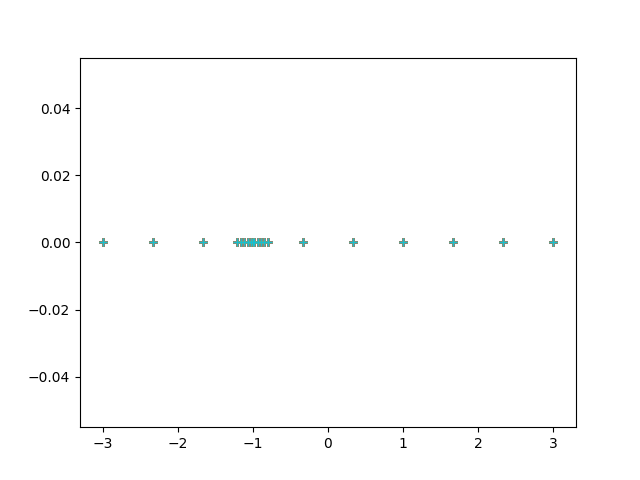

In [17]:
%matplotlib widget
plt.close(11)

fig = plt.figure(11)
ax = fig.add_subplot(111)

ax.plot(x_list, e_list,'+')


In [110]:
np.argwhere(x_list>-1.05)[0]

array([35])

In [86]:
ring, ring_L = full_lat.build_ringops(0)



In [120]:
np.imag(v_list[56][0,:])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

zero for i=25
zero for i=26
zero for i=27
zero for i=28
zero for i=29
zero for i=30
zero for i=31
zero for i=32
zero for i=33
zero for i=34
zero for i=35
zero for i=36
zero for i=37
zero for i=39
zero for i=40
zero for i=41
zero for i=42
zero for i=43
zero for i=44
zero for i=45
zero for i=46
zero for i=47
zero for i=48
zero for i=49


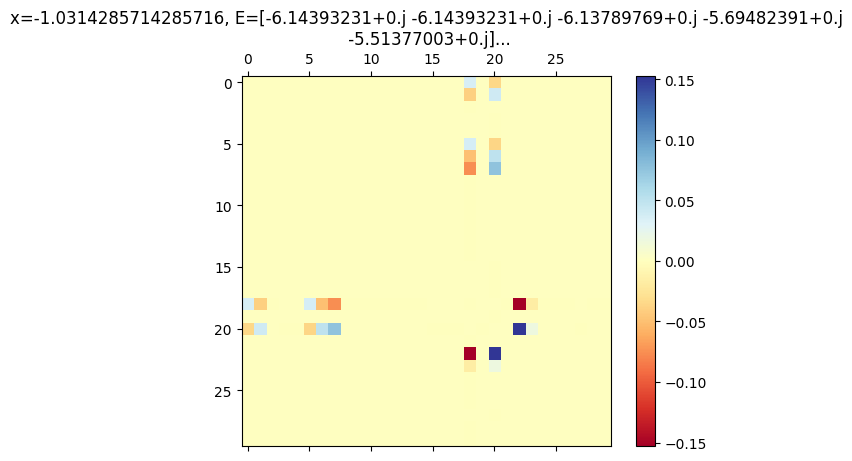

In [124]:
%matplotlib inline
# plt.close(12)
plt.close('all')

op = (ring_L[4] - ring_L[4].T)/1.0j

for i in range(25,50):
    
    v = v_list[i]
    if np.max(np.imag(v)) < 1e-10:
        print(f"zero for i={i}")
        continue

    
    
    
    fig, ax = plt.subplots()
    c = ax.matshow(np.real(v.conj().T @ op.todense() @v),cmap=plt.colormaps['RdYlBu'])
    fig.colorbar(c)
    ax.set_title(f'x={x_list[i]}, E={e_list[i][:5]}...')

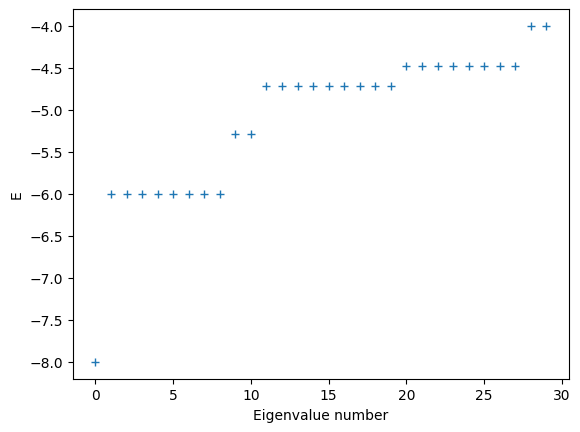

In [45]:
# plt.plot(np.real(np.sort(e1)),'kx',label='lanczos')
for s in res:
    e, v = res[s]
    plt.plot(np.sort(e)[:30],'+', label=str(s))

plt.xlabel('Eigenvalue number')
plt.ylabel("E")

# plt.plot(np.sort(res[0][0]),'ko')

# plt.legend()
exps, exps_im = ring_exp_values(full_lat, 0, res[0][1][:,:6], include_imag=True)

In [19]:
lat.bonds[0].color

0

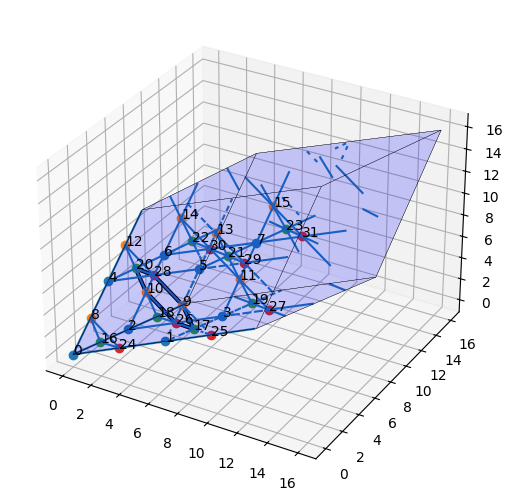

In [20]:
fig =plt.figure()
ax=fig.add_axes([0,0,1,1],projection='3d')

rf = full_lat.ringflips[0]

hexa = [full_lat.lattice.atoms[j].xyz for j in rf.members]

X = [float(hexa[-1][0])]
Y = [float(hexa[-1][1])]
Z = [float(hexa[-1][2])]

for xyz in hexa:
    X.append(float(xyz[0]))
    Y.append(float(xyz[1]))
    Z.append(float(xyz[2]))
    
ax.plot(X, Y ,Z,color='k',lw=3)
# ax.plot([0,-1],[0,-1],[0,-1],lw=3)
visual.plot_cell(ax, full_lat.lattice)


In [17]:
full_lat.lattice.atoms[0].sl_name

'0'

In [18]:

def visualise_state(ax, l:RingflipHamiltonian, state:int):
    # input->state: understood as a bitstring
    for i,a in enumerate(l.lattice.atoms):
        
        
        color='k'if (state&(1<<i)) == 0 else 'white'

        ax.plot(*a.xyz, 'o', 
                color = color,
               markeredgecolor='k' 
               )
        

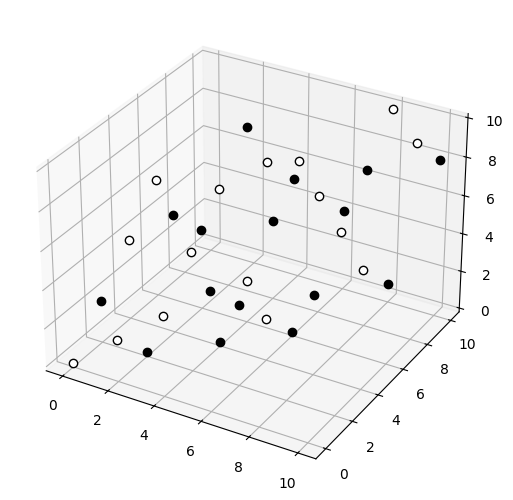

In [20]:

fig =plt.figure()
ax=fig.add_axes([0,0,1,1],projection='3d')

visualise_state(ax, full_lat, full_lat.basis[0][55])


In [ ]:
res = partition_polarisation_sectors(full_lat.basis, full_lat.lattice)

In [ ]:
res

In [ ]:
len(res[(4,4,4,4)])